In [1]:
import torch
import torch.nn as nn
import numpy as np

from splitters import get_imbalanced_client_loaders
from states import ClientState, AdamClientState
from compresors import CompressedModel, IdenticalCompressor, ExpDitheringCompressor, RandKCompressor, TopKCompressor
from validation_utils import total_evaluation
from algorithms.feen import feen_training_step
from algorithms.fedavg import fed_avg_training_step
from models import ResNet18

In [ ]:
num_clients = 10
gamma = 1e-4
lmbd = 0.1
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

models = [CompressedModel(ResNet18(num_clients), TopKCompressor()).to(device) for _ in range(num_clients)]
client_optimizers = [torch.optim.Adam(model.parameters(), lr=1e-5) for model in models]
clients_states = [AdamClientState(model, lmbd, gamma) for model in models]
criterion = nn.CrossEntropyLoss()


In [3]:
local_train_loader, local_test_loader, common_loader, validation_loader = get_imbalanced_client_loaders(num_clients, classes_per_client=3)

In [4]:
import matplotlib.pyplot as plt 
import scipy.stats as stats

def plot_metrics(metrics):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
     
    # Plot Metric 1
    # axes[0, 0].plot(epochs, metric1, marker='o', color='b')
    x_labels = np.arange(len(metrics['ensemble_accuracy']))

    axes[0, 0].plot(x_labels, metrics['ensemble_accuracy'], color='b')
    axes[0, 0].set_title('Ensembled Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(True)

    # Plot Metric 2

    vals = np.array(metrics['single_accuracies'])
    means = np.mean(vals, -1)
    
    axes[0, 1].plot(x_labels, means, color='g')
    # print(means, means - confidence_intervals)
    # axes[0, 1].fill_between(x_labels, means - confidence_intervals, means + confidence_intervals, color='blue', alpha=0.2)
    axes[0, 1].set_title('Single Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].grid(True)

    vals = np.array(metrics['local_accuracies'])
    means = np.mean(vals, -1)
    # confidence_intervals = [
    #     stats.sem(vals) * stats.t.ppf((1 + 0.95) / 2., vals.shape[1] - 1)
    # ]
    
    axes[1, 0].plot(x_labels, means, color='g')
    # axes[0, 1].fill_between(x_labels, means - confidence_intervals, means + confidence_intervals, color='blue', alpha=0.2)
    axes[1, 0].set_title('Local Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].grid(True)

    # Plot Loss
    local_loss = np.array(metrics['local_loss'])
    reg_loss = np.array(metrics['reg_loss'])

    axes[1, 1].plot(x_labels, local_loss, color='b', label='Local Loss')
    axes[1, 1].plot(x_labels, reg_loss, color='r', label='Regularization Loss')
    axes[1, 1].set_title('Losses')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    plt.show()

In [5]:
# local_loss_history

Ensemble accuracy 0.390 || Single accuracy = 0.180 +- 0.025 || Local accuracy = 0.206 +- 0.121 || Lambda 3.7735360253530725


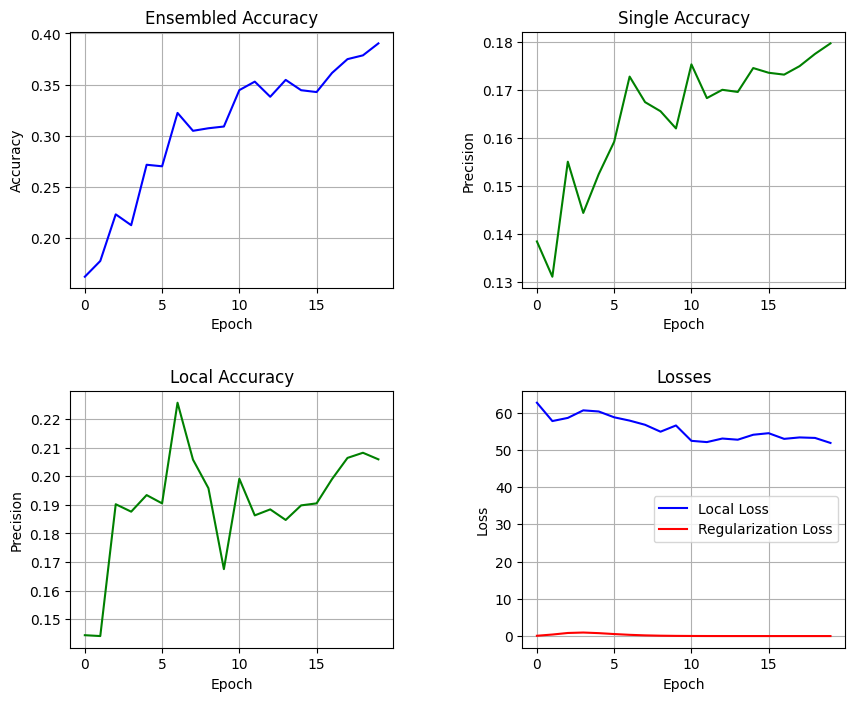

In [5]:
from IPython.display import clear_output

metrics_history = {
    'ensemble_accuracy': [],
    'single_accuracies': [],
    'local_accuracies': [],
    'local_loss': [],
    'reg_loss': [],
}

local_loss_history = []
reg_loss_history = []
for i in range(200):
    local_loss, reg_loss = feen_training_step(models, clients_states, client_optimizers, 
                       local_train_loader, common_loader, criterion, device, n_global_steps=1, n_local_steps=3)
    local_loss_history.append(local_loss)
    reg_loss_history.append(reg_loss)
    if (i + 1) % 10 == 0:
        metrics = total_evaluation(models, local_test_loader, validation_loader, device)
        metrics_history['ensemble_accuracy'].append(metrics['ensemble_accuracy'])
        metrics_history['single_accuracies'].append(metrics['single_accuracies'])
        metrics_history['local_accuracies'].append(metrics['local_accuracies'])
        metrics_history['local_loss'].append(np.mean(local_loss_history[-10:]))
        metrics_history['reg_loss'].append(np.mean(reg_loss_history[-10:]))
        clear_output()
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f} || Lambda {clients_states[0].lmbd}")
        plot_metrics(metrics_history)
        for state in clients_states:
            state.lmbd *= 0.95

In [6]:
# plot_metrics(metrics_history)

Ensemble accuracy 0.534 || Single accuracy = 0.358 +- 0.022 || Local accuracy = 0.529 +- 0.099


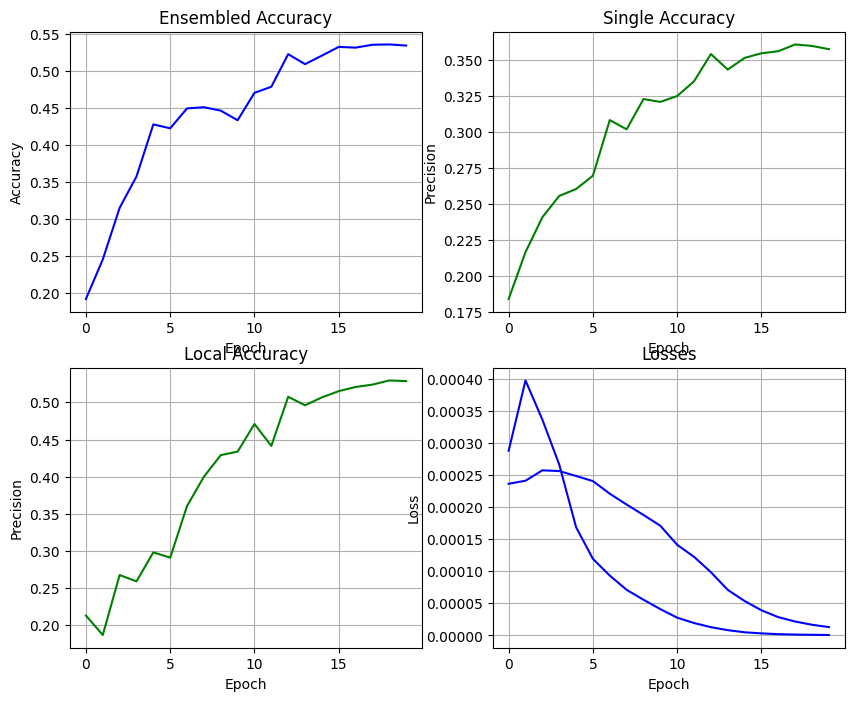

In [ ]:
from IPython.display import clear_output

metrics_history = {
    'ensemble_accuracy': [],
    'single_accuracies': [],
    'local_accuracies': [],
    'local_loss': [],
    'reg_loss': [],
}

local_loss_history = []
reg_loss_history = []
for i in range(200):
    local_loss, reg_loss = feen_training_step(models, clients_states, client_optimizers, 
                       local_train_loader, common_loader, criterion, device, n_global_steps=1, n_local_steps=3)
    local_loss_history.append(local_loss)
    reg_loss_history.append(reg_loss)
    if (i + 1) % 10 == 0:
        metrics = total_evaluation(models, local_test_loader, validation_loader, device)
        metrics_history['ensemble_accuracy'].append(metrics['ensemble_accuracy'])
        metrics_history['single_accuracies'].append(metrics['single_accuracies'])
        metrics_history['local_accuracies'].append(metrics['local_accuracies'])
        metrics_history['local_loss'].append(np.mean(local_loss_history[-10:]))
        metrics_history['reg_loss'].append(np.mean(reg_loss_history[-10:]))
        clear_output()
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f} || Lambda {state.lmbd}")
        plot_metrics(metrics_history)
        for state in clients_states:
            state.lmbd *= 0.95

Ensemble accuracy 0.537 || Single accuracy = 0.360 +- 0.020 || Local accuracy = 0.538 +- 0.102 || Lambda 0.01215766545905694


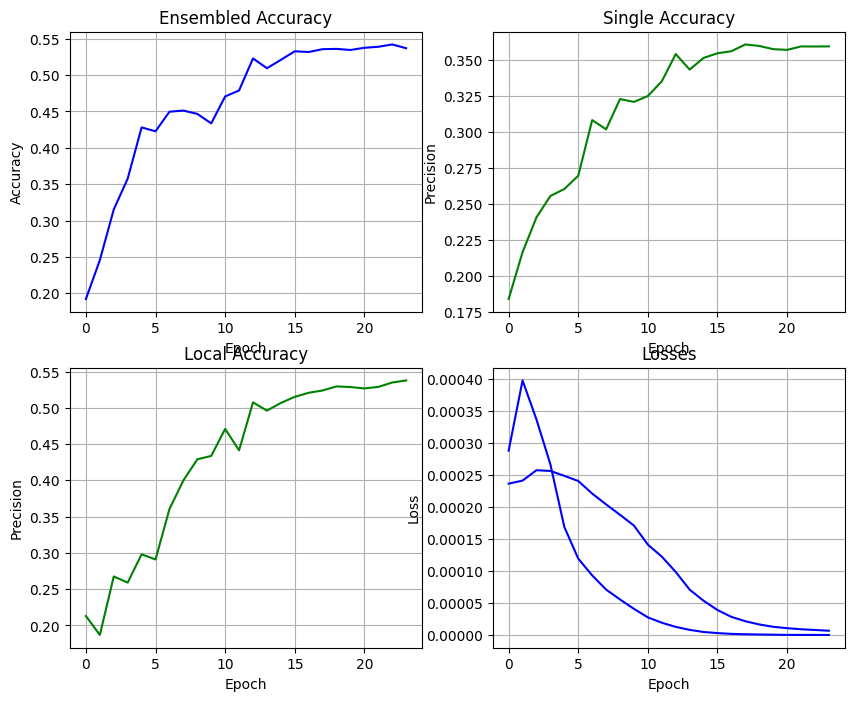

KeyboardInterrupt: 

In [6]:
# for i in range(200):
#     local_loss, reg_loss = feen_training_step(models, clients_states, client_optimizers, 
#                        local_train_loader, common_loader, criterion, device, n_global_steps=1, n_local_steps=3)
#     local_loss_history.append(local_loss)
#     reg_loss_history.append(reg_loss)
#     if (i + 1) % 10 == 0:
#         metrics = total_evaluation(models, local_test_loader, validation_loader, device)
#         metrics_history['ensemble_accuracy'].append(metrics['ensemble_accuracy'])
#         metrics_history['single_accuracies'].append(metrics['single_accuracies'])
#         metrics_history['local_accuracies'].append(metrics['local_accuracies'])
#         metrics_history['local_loss'].append(np.mean(local_loss_history[-10:]))
#         metrics_history['reg_loss'].append(np.mean(reg_loss_history[-10:]))
#         clear_output()
#         print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f} || Lambda {state.lmbd}")
#         plot_metrics(metrics_history)
#         # for state in clients_states:
#         #     state.lmbd *= 0.95

In [ ]:
from IPython.display import clear_output

metrics_history = {
    'ensemble_accuracy': [],
    'single_accuracies': [],
    'local_accuracies': [],
}

for i in range(200):
    feen_training_step(models, clients_states, client_optimizers, 
                       local_train_loader, common_loader, criterion, device, n_global_steps=1, n_local_steps=3)
    if (i + 1) % 10 == 0:
        metrics = total_evaluation(models, local_test_loader, validation_loader, device)
        metrics_history['ensemble_accuracy'].append(metrics['ensemble_accuracy'])
        metrics_history['single_accuracies'].append(metrics['single_accuracies'])
        metrics_history['local_accuracies'].append(metrics['local_accuracies'])
        clear_output()
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")
        plot_metrics(metrics_history)
        
        for state in clients_states:
            state.lmbd *= 0.9

Local loss avg = 0.0002237516097227732, Reg loss part 4.891982158975831e-05
Local loss avg = 0.0002178575758139292, Reg loss part 0.00011812045922852122
Local loss avg = 0.0002160234089692434, Reg loss part 0.00018317568174097687
Local loss avg = 0.0002138231388727824, Reg loss part 0.00024900641098308065
Local loss avg = 0.00021417370200157168, Reg loss part 0.00028624789556488397
Local loss avg = 0.0002116412882010142, Reg loss part 0.00033625962193279215
Local loss avg = 0.0002110505549112956, Reg loss part 0.0003804053325438872
Local loss avg = 0.00020889409820238752, Reg loss part 0.00041923916335993757
Local loss avg = 0.00020523455421129862, Reg loss part 0.0004335728764999658
Local loss avg = 0.00020331803719202677, Reg loss part 0.00044396166631486265
Ensemble accuracy 0.181 || Single accuracy = 0.178 +- 0.024 || Local accuracy = 0.288 +- 0.106
Local loss avg = 0.00020392795721689861, Reg loss part 0.0003700587966401751
Local loss avg = 0.00020092008550961812, Reg loss part 0.

In [ ]:
models_fedavg = [ResNet18(num_clients).to(device) for _ in range(num_clients)]
client_optimizers_fedavg = [torch.optim.Adam(model.parameters(), lr=1e-3) for model in models_fedavg]

for i in range(100):
    fed_avg_training_step(models_fedavg, client_optimizers_fedavg, local_train_loader, criterion, device)
    # feen_training_step(models, clients_states, client_optimizers, 
    #                    local_train_loader, common_loader, criterion, device)
    if i % 10 == 0:
        metrics = total_evaluation(models_fedavg, local_test_loader, validation_loader, device)
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")


Ensemble accuracy 0.100 || Single accuracy = 0.100 +- 0.000 || Local accuracy = 0.233 +- 0.153
Ensemble accuracy 0.167 || Single accuracy = 0.156 +- 0.018 || Local accuracy = 0.254 +- 0.129
Ensemble accuracy 0.258 || Single accuracy = 0.236 +- 0.037 || Local accuracy = 0.381 +- 0.121
Ensemble accuracy 0.274 || Single accuracy = 0.232 +- 0.037 || Local accuracy = 0.386 +- 0.080
Ensemble accuracy 0.295 || Single accuracy = 0.240 +- 0.017 || Local accuracy = 0.434 +- 0.181
Ensemble accuracy 0.231 || Single accuracy = 0.214 +- 0.038 || Local accuracy = 0.433 +- 0.090
Ensemble accuracy 0.308 || Single accuracy = 0.278 +- 0.049 || Local accuracy = 0.475 +- 0.113
Ensemble accuracy 0.334 || Single accuracy = 0.274 +- 0.050 || Local accuracy = 0.527 +- 0.132
Ensemble accuracy 0.363 || Single accuracy = 0.262 +- 0.063 || Local accuracy = 0.627 +- 0.155
Ensemble accuracy 0.333 || Single accuracy = 0.256 +- 0.038 || Local accuracy = 0.771 +- 0.116


In [ ]:
assert False

In [4]:
for i in range(200):
    feen_training_step(models, clients_states, client_optimizers, 
                       local_train_loader, common_loader, criterion, device)
    if i % 10 == 0:
        metrics = total_evaluation(models, local_test_loader, validation_loader, device)
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")


Ensemble accuracy 0.158 || Single accuracy = 0.118 +- 0.021 || Local accuracy = 0.168 +- 0.034
Ensemble accuracy 0.291 || Single accuracy = 0.289 +- 0.021 || Local accuracy = 0.403 +- 0.038
Ensemble accuracy 0.358 || Single accuracy = 0.328 +- 0.031 || Local accuracy = 0.468 +- 0.052
Ensemble accuracy 0.392 || Single accuracy = 0.347 +- 0.040 || Local accuracy = 0.491 +- 0.053
Ensemble accuracy 0.409 || Single accuracy = 0.359 +- 0.026 || Local accuracy = 0.518 +- 0.040
Ensemble accuracy 0.414 || Single accuracy = 0.374 +- 0.045 || Local accuracy = 0.529 +- 0.070
Ensemble accuracy 0.471 || Single accuracy = 0.384 +- 0.033 || Local accuracy = 0.540 +- 0.051
Ensemble accuracy 0.472 || Single accuracy = 0.396 +- 0.025 || Local accuracy = 0.563 +- 0.042
Ensemble accuracy 0.490 || Single accuracy = 0.400 +- 0.025 || Local accuracy = 0.568 +- 0.048
Ensemble accuracy 0.533 || Single accuracy = 0.405 +- 0.028 || Local accuracy = 0.577 +- 0.039
Ensemble accuracy 0.521 || Single accuracy = 0.399

In [ ]:
assert False

In [25]:
for i in range(200):
    feen_training_step(models, clients_states, client_optimizers, 
                       local_train_loader, common_loader, criterion, device)
    if i % 10 == 0:
        metrics = total_evaluation(models, local_test_loader, validation_loader, device)
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")


Ensemble accuracy 0.102 || Single accuracy = 0.114 +- 0.015 || Local accuracy = 0.163 +- 0.029
Ensemble accuracy 0.248 || Single accuracy = 0.275 +- 0.044 || Local accuracy = 0.391 +- 0.058
Ensemble accuracy 0.344 || Single accuracy = 0.324 +- 0.023 || Local accuracy = 0.460 +- 0.036
Ensemble accuracy 0.392 || Single accuracy = 0.342 +- 0.027 || Local accuracy = 0.490 +- 0.035
Ensemble accuracy 0.429 || Single accuracy = 0.366 +- 0.031 || Local accuracy = 0.527 +- 0.039
Ensemble accuracy 0.393 || Single accuracy = 0.366 +- 0.029 || Local accuracy = 0.520 +- 0.038
Ensemble accuracy 0.463 || Single accuracy = 0.372 +- 0.043 || Local accuracy = 0.530 +- 0.072
Ensemble accuracy 0.460 || Single accuracy = 0.377 +- 0.035 || Local accuracy = 0.530 +- 0.038
Ensemble accuracy 0.497 || Single accuracy = 0.398 +- 0.033 || Local accuracy = 0.571 +- 0.050
Ensemble accuracy 0.528 || Single accuracy = 0.386 +- 0.029 || Local accuracy = 0.554 +- 0.044
Ensemble accuracy 0.573 || Single accuracy = 0.395

In [6]:
for i in range(100):
    feen_training_step(models, clients_states, client_optimizers, 
                       local_train_loader, common_loader, criterion, device)
    if i % 10 == 0:
        metrics = total_evaluation(models, local_test_loader, validation_loader, device)
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")


Ensemble accuracy 0.453 || Single accuracy = 0.347 +- 0.019 || Local accuracy = 0.487 +- 0.032
Ensemble accuracy 0.451 || Single accuracy = 0.347 +- 0.020 || Local accuracy = 0.491 +- 0.032
Ensemble accuracy 0.459 || Single accuracy = 0.348 +- 0.019 || Local accuracy = 0.487 +- 0.032
Ensemble accuracy 0.463 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.488 +- 0.031
Ensemble accuracy 0.461 || Single accuracy = 0.348 +- 0.019 || Local accuracy = 0.490 +- 0.031
Ensemble accuracy 0.462 || Single accuracy = 0.349 +- 0.019 || Local accuracy = 0.489 +- 0.034
Ensemble accuracy 0.463 || Single accuracy = 0.348 +- 0.019 || Local accuracy = 0.490 +- 0.032
Ensemble accuracy 0.463 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.489 +- 0.036
Ensemble accuracy 0.466 || Single accuracy = 0.347 +- 0.020 || Local accuracy = 0.486 +- 0.031
Ensemble accuracy 0.464 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.487 +- 0.031


In [ ]:
for i in range(100):
    feen_training_step(models, clients_states, client_optimizers, 
                       local_train_loader, common_loader, criterion, device)
    if i % 10 == 0:
        metrics = total_evaluation(models, local_test_loader, validation_loader, device)
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")


Ensemble accuracy 0.466 || Single accuracy = 0.348 +- 0.019 || Local accuracy = 0.488 +- 0.031
Ensemble accuracy 0.467 || Single accuracy = 0.348 +- 0.021 || Local accuracy = 0.485 +- 0.034
Ensemble accuracy 0.468 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.490 +- 0.030
Ensemble accuracy 0.467 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.490 +- 0.032
Ensemble accuracy 0.468 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.490 +- 0.033
Ensemble accuracy 0.468 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.489 +- 0.033
Ensemble accuracy 0.468 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.487 +- 0.031
Ensemble accuracy 0.470 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.484 +- 0.031
Ensemble accuracy 0.469 || Single accuracy = 0.347 +- 0.020 || Local accuracy = 0.487 +- 0.030
Ensemble accuracy 0.468 || Single accuracy = 0.348 +- 0.020 || Local accuracy = 0.488 +- 0.028


## Only local data training

In [10]:
models_fedavg = [ResNet18(num_clients).to(device) for _ in range(num_clients)]
client_optimizers_fedavg = [torch.optim.Adam(model.parameters(), lr=1e-3) for model in models_fedavg]

In [11]:
for i in range(100):
    fed_avg_training_step(models_fedavg, client_optimizers_fedavg, local_train_loader, criterion, device)
    # feen_training_step(models, clients_states, client_optimizers, 
    #                    local_train_loader, common_loader, criterion, device)
    if i % 10 == 0:
        metrics = total_evaluation(models_fedavg, local_test_loader, validation_loader, device)
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")


Ensemble accuracy 0.100 || Single accuracy = 0.100 +- 0.000 || Local accuracy = 0.127 +- 0.044
Ensemble accuracy 0.148 || Single accuracy = 0.151 +- 0.022 || Local accuracy = 0.184 +- 0.034
Ensemble accuracy 0.432 || Single accuracy = 0.416 +- 0.036 || Local accuracy = 0.410 +- 0.061
Ensemble accuracy 0.474 || Single accuracy = 0.442 +- 0.034 || Local accuracy = 0.448 +- 0.035
Ensemble accuracy 0.523 || Single accuracy = 0.476 +- 0.052 || Local accuracy = 0.459 +- 0.081
Ensemble accuracy 0.624 || Single accuracy = 0.555 +- 0.032 || Local accuracy = 0.548 +- 0.057
Ensemble accuracy 0.659 || Single accuracy = 0.587 +- 0.040 || Local accuracy = 0.585 +- 0.090
Ensemble accuracy 0.686 || Single accuracy = 0.601 +- 0.046 || Local accuracy = 0.588 +- 0.077
Ensemble accuracy 0.719 || Single accuracy = 0.637 +- 0.027 || Local accuracy = 0.636 +- 0.071
Ensemble accuracy 0.716 || Single accuracy = 0.641 +- 0.026 || Local accuracy = 0.669 +- 0.072


In [12]:
for i in range(100):
    fed_avg_training_step(models_fedavg, client_optimizers_fedavg, local_train_loader, criterion, device)
    # feen_training_step(models, clients_states, client_optimizers, 
    #                    local_train_loader, common_loader, criterion, device)
    if i % 10 == 0:
        metrics = total_evaluation(models_fedavg, local_test_loader, validation_loader, device)
        print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")


Ensemble accuracy 0.678 || Single accuracy = 0.631 +- 0.040 || Local accuracy = 0.650 +- 0.068
Ensemble accuracy 0.703 || Single accuracy = 0.666 +- 0.030 || Local accuracy = 0.714 +- 0.042
Ensemble accuracy 0.731 || Single accuracy = 0.689 +- 0.020 || Local accuracy = 0.758 +- 0.038
Ensemble accuracy 0.741 || Single accuracy = 0.706 +- 0.018 || Local accuracy = 0.786 +- 0.041
Ensemble accuracy 0.718 || Single accuracy = 0.675 +- 0.024 || Local accuracy = 0.780 +- 0.026
Ensemble accuracy 0.745 || Single accuracy = 0.715 +- 0.013 || Local accuracy = 0.810 +- 0.023
Ensemble accuracy 0.736 || Single accuracy = 0.674 +- 0.046 || Local accuracy = 0.796 +- 0.037
Ensemble accuracy 0.751 || Single accuracy = 0.686 +- 0.042 || Local accuracy = 0.807 +- 0.038
Ensemble accuracy 0.754 || Single accuracy = 0.692 +- 0.039 || Local accuracy = 0.826 +- 0.028
Ensemble accuracy 0.760 || Single accuracy = 0.702 +- 0.044 || Local accuracy = 0.844 +- 0.015


In [14]:
metrics = total_evaluation(models_fedavg, local_test_loader, validation_loader, device)
print(f"Ensemble accuracy {metrics['ensemble_accuracy']:.3f} || Single accuracy = {np.mean(metrics['single_accuracies']):.3f} +- {np.std(metrics['single_accuracies']):.3f} || Local accuracy = {np.mean(metrics['local_accuracies']):.3f} +- {np.std(metrics['local_accuracies']):.3f}")

Ensemble accuracy 0.771 || Single accuracy = 0.708 +- 0.040 || Local accuracy = 0.840 +- 0.020


In [18]:
p = [p for p in models[0].parameters()][0]
p.shape

torch.Size([64, 3, 3, 3])

In [21]:
(p ** 2).sum()

tensor(21.2068, device='cuda:2', grad_fn=<SumBackward0>)

In [19]:
torch.norm(p, p=2)

tensor(4.6051, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>)